# Forecasting Sunspot Numbers: A Comparative Analysis of Predictive Models
Data: https://www.sidc.be/SILSO/datafiles


In [3]:
import pandas as pd
import matplotlib.pyplot as plt


## Data Preprocessing and Analysis

First, let's load and inspect the data to understand its structure and quality.

**Dataset Description:**

- **Data Type:** Monthly mean total sunspot number
- **Time Range:** January 1749 - Last elapsed month
- **Description:** Monthly mean total sunspot number obtained by averaging daily total sunspot numbers for each calendar month. Data is available since 1749 due to sparse observations before that year.
- **Error Values:** A value of -1 indicates a missing observation. Monthly standard deviation is derived from daily values, and standard error on monthly mean values can be computed.
- **Data Format:** Available in both plain ASCII text and CSV formats.
- **Columns (CSV):**
  1. Year
  2. Month
  3. Date in fraction of year
  4. Monthly mean total sunspot number
  5. Monthly mean standard deviation of sunspot numbers
  6. Number of observations used
  7. Definitive/provisional marker (1 for definitive, 0 for provisional)

In [6]:
df = pd.read_csv(
    "/content/SN_m_tot_V2.0.csv",
    delimiter=";",
    header=None,
    names=[
        "year",
        "month",
        "decimal_year",
        "sunspot_number",
        "std_dev",
        "observations",
        "definitive",
    ],
)

df.head(13)

,year,month,decimal_year,sunspot_number,std_dev,observations,definitive
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
5,1749,6,1749.455,139.2,-1.0,-1,1
6,1749,7,1749.538,158.0,-1.0,-1,1
7,1749,8,1749.623,110.5,-1.0,-1,1
8,1749,9,1749.707,126.5,-1.0,-1,1
9,1749,10,1749.790,125.8,-1.0,-1,1


In [7]:
print(df.isnull().sum())

year              0
month             0
decimal_year      0
sunspot_number    0
std_dev           0
observations      0
definitive        0
dtype: int64


Next, we'll convert the year and month columns to a datetime object and set the date column as the index for time series analysis.

In [8]:
# Convert year and month into a datetime object
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))

# Set this new date column as the index for easier time series analysis
df.set_index('date', inplace=True)

# Drop the original Year and Month columns
#df.drop(['year', 'month'], axis=1, inplace=True)

In [10]:
# Remove rows where "observations" is -1 because that indicates missing values

df = df[df["observations"] != -1]

In [11]:
df.head()

,year,month,decimal_year,sunspot_number,std_dev,observations,definitive
date,,,,,,,
1818-01-01,1818,1,1818.042,58.1,9.7,8,1
1818-02-01,1818,2,1818.123,37.4,7.8,14,1
1818-03-01,1818,3,1818.204,42.4,8.3,14,1
1818-04-01,1818,4,1818.288,57.5,9.6,21,1
1818-05-01,1818,5,1818.371,88.5,11.9,25,1


Let's visualize the sunspot numbers over time to understand their distribution and patterns.



              year        month  decimal_year  sunspot_number      std_dev  \
count  2475.000000  2475.000000   2475.000000     2475.000000  2475.000000   
mean   1920.625455     6.494545   1921.122990       83.244283     7.875030   
std      59.551367     3.454326     59.551237       68.288561     4.217488   
min    1818.000000     1.000000   1818.042000        0.000000     0.000000   
25%    1869.000000     3.000000   1869.580500       24.400000     4.400000   
50%    1921.000000     6.000000   1921.123000       70.500000     7.600000   
75%    1972.000000     9.000000   1972.666000      126.050000    10.500000   
max    2024.000000    12.000000   2024.206000      359.400000    29.400000   

       observations   definitive  
count   2475.000000  2475.000000  
mean     157.430707     0.998788  
std      278.017391     0.034801  
min        0.000000     0.000000  
25%       30.000000     1.000000  
50%       31.000000     1.000000  
75%       31.000000     1.000000  
max     1587.0000

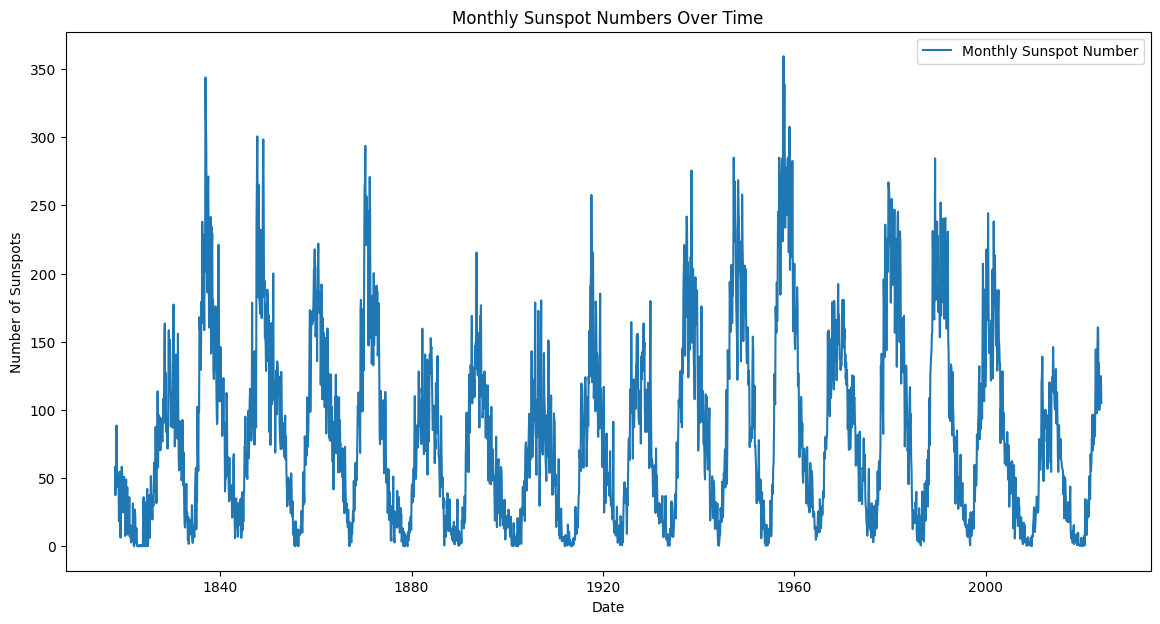

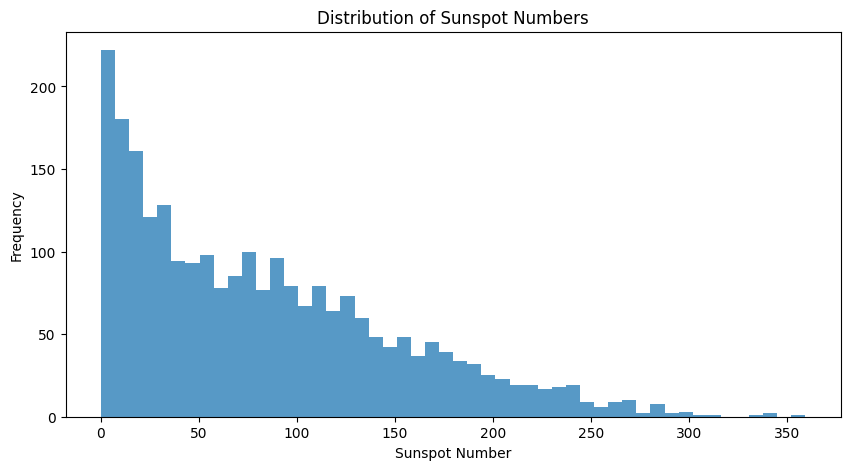

In [12]:
# Statistical summary of the data
print(df.describe())

# Plotting sunspot numbers over time
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['sunspot_number'], label='Monthly Sunspot Number')
plt.title('Monthly Sunspot Numbers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.legend()
plt.show()

# Histogram to examine the distribution of sunspot numbers
plt.figure(figsize=(10, 5))
plt.hist(df['sunspot_number'], bins=50, alpha=0.75)
plt.title('Distribution of Sunspot Numbers')
plt.xlabel('Sunspot Number')
plt.ylabel('Frequency')
plt.show()


In [13]:
df.head()
df.shape

(2475, 7)

## Time Series Modeling
We'll now proceed with time series modeling, including feature engineering and model training.

In [14]:
# Creating lagged features
for lag in range(1, 13):  # 12 months, you can choose different lags based on domain knowledge
    df[f'sunspot_number_lag_{lag}'] = df['sunspot_number'].shift(lag)


In [15]:
# Creating rolling window features of window size 12 months
df['rolling_mean'] = df['sunspot_number'].rolling(window=12).mean()
df['rolling_std'] = df['sunspot_number'].rolling(window=12).std()


In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition of the sunspot time series
decomposition = seasonal_decompose(df['sunspot_number'], model='additive', period=12)
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal


In [17]:
df.isna().sum()

year                      0
month                     0
decimal_year              0
sunspot_number            0
std_dev                   0
observations              0
definitive                0
sunspot_number_lag_1      1
sunspot_number_lag_2      2
sunspot_number_lag_3      3
sunspot_number_lag_4      4
sunspot_number_lag_5      5
sunspot_number_lag_6      6
sunspot_number_lag_7      7
sunspot_number_lag_8      8
sunspot_number_lag_9      9
sunspot_number_lag_10    10
sunspot_number_lag_11    11
sunspot_number_lag_12    12
rolling_mean             11
rolling_std              11
trend                    12
seasonal                  0
dtype: int64

In [18]:
import numpy as np

# Encoding 'month' as a cyclical continuous feature
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)


In [19]:
df.head()

,year,month,decimal_year,sunspot_number,std_dev,observations,definitive,sunspot_number_lag_1,sunspot_number_lag_2,sunspot_number_lag_3,...,sunspot_number_lag_9,sunspot_number_lag_10,sunspot_number_lag_11,sunspot_number_lag_12,rolling_mean,rolling_std,trend,seasonal,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
1818-01-01,1818,1,1818.042,58.1,9.7,8,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.385402,0.500000,8.660254e-01
1818-02-01,1818,2,1818.123,37.4,7.8,14,1,58.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.158613,0.866025,5.000000e-01
1818-03-01,1818,3,1818.204,42.4,8.3,14,1,37.4,58.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.449711,1.000000,6.123234e-17
1818-04-01,1818,4,1818.288,57.5,9.6,21,1,42.4,37.4,58.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.428471,0.866025,-5.000000e-01
1818-05-01,1818,5,1818.371,88.5,11.9,25,1,57.5,42.4,37.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.393663,0.500000,-8.660254e-01


In [20]:
# Drop rows with NaN values
df_cleaned = df.dropna()


In [21]:
df_cleaned.shape

(2457, 25)

In [22]:
df_cleaned

,year,month,decimal_year,sunspot_number,std_dev,observations,definitive,sunspot_number_lag_1,sunspot_number_lag_2,sunspot_number_lag_3,...,sunspot_number_lag_9,sunspot_number_lag_10,sunspot_number_lag_11,sunspot_number_lag_12,rolling_mean,rolling_std,trend,seasonal,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
1819-01-01,1819,1,1819.042,54.7,9.4,12,1,43.0,18.3,52.8,...,57.5,42.4,37.4,58.1,49.850000,16.557805,39.995833,-3.385402,5.000000e-01,8.660254e-01
1819-02-01,1819,2,1819.123,34.6,7.5,10,1,54.7,43.0,18.3,...,88.5,57.5,42.4,37.4,49.616667,16.767600,39.854167,-0.158613,8.660254e-01,5.000000e-01
1819-03-01,1819,3,1819.204,6.3,3.6,23,1,34.6,54.7,43.0,...,60.8,88.5,57.5,42.4,46.608333,20.907435,38.700000,-0.449711,1.000000e+00,6.123234e-17
1819-04-01,1819,4,1819.288,33.7,7.4,23,1,6.3,34.6,54.7,...,46.8,60.8,88.5,57.5,44.625000,20.909160,37.637500,-0.428471,8.660254e-01,-5.000000e-01
1819-05-01,1819,5,1819.371,32.6,7.3,31,1,33.7,6.3,34.6,...,52.6,46.8,60.8,88.5,39.966667,15.863929,38.329167,0.393663,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,2023,5,2023.371,137.4,19.6,1240,1,97.6,123.3,111.3,...,74.6,91.4,70.3,96.5,102.925000,23.597655,124.166667,0.393663,5.000000e-01,-8.660254e-01
2023-06-01,2023,6,2023.453,160.5,20.0,1248,1,137.4,97.6,123.3,...,96.0,74.6,91.4,70.3,110.441667,26.453783,125.304167,1.011529,1.224647e-16,-1.000000e+00
2023-07-01,2023,7,2023.538,160.0,18.2,1278,1,160.5,137.4,97.6,...,95.5,96.0,74.6,91.4,116.158333,29.231224,124.441667,1.026620,-5.000000e-01,-8.660254e-01


In [25]:
# The last solar minimum was around 2020, so we'll use this as our split date
split_date = pd.to_datetime('2020-01-01')

# Split into train and test sets
train_df = df_cleaned.loc[df_cleaned.index < split_date]
test_df = df_cleaned.loc[df_cleaned.index >= split_date]

# Print the shapes of the train and test sets to confirm the split
print("Training Set Shape:", train_df.shape)
print("Testing Set Shape:", test_df.shape)

Training Set Shape: (2412, 25)
Testing Set Shape: (45, 25)


Results of Dickey-Fuller Test:
Test Statistic                -9.613417e+00
p-value                        1.786509e-16
#Lags Used                     2.700000e+01
Number of Observations Used    2.384000e+03
Critical Value (1%)           -3.433096e+00
Critical Value (5%)           -2.862753e+00
Critical Value (10%)          -2.567416e+00
dtype: float64


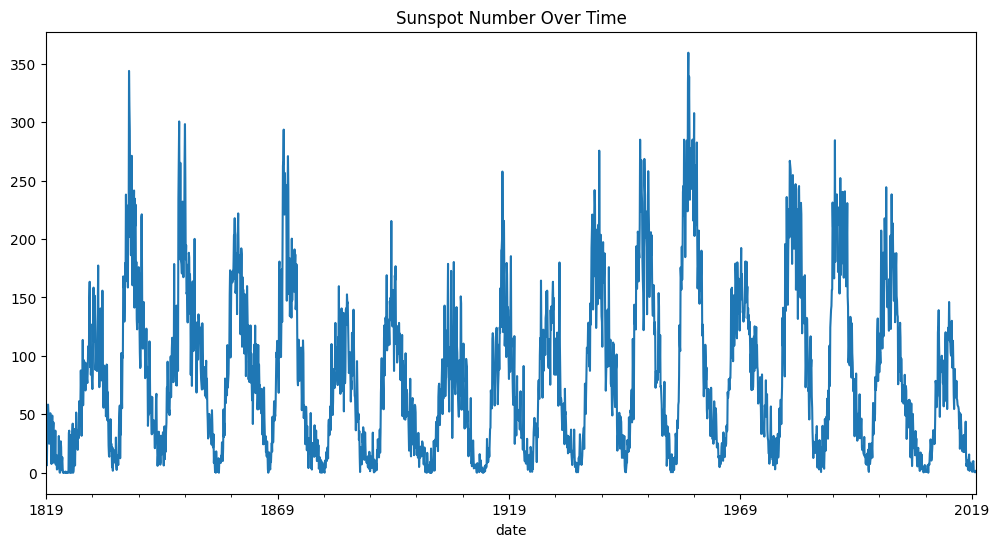

In [26]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


# Function to perform the Dickey-Fuller test
def test_stationarity(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)


# Test stationarity on sunspot_number
test_stationarity(train_df["sunspot_number"])

# Plotting the sunspot number
train_df["sunspot_number"].plot(title="Sunspot Number Over Time", figsize=(12, 6))
plt.show()

In [ ]:
pip install pmdarima

## SARIMA Model Forecasting

Let's forecast sunspot numbers using the SARIMA model and visualize the results.

In [ ]:
from pmdarima import auto_arima

# Automatically fit a SARIMA model
sarima_model = auto_arima(
    train_df["sunspot_number"],
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    d=0,
    start_p=1,
    start_q=1,
    start_P=1,
    start_Q=1,
)

# Output the summary of the model
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=22436.999, Time=3.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=27252.723, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=22701.366, Time=1.70 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24531.720, Time=2.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=29449.302, Time=0.12 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=22435.478, Time=2.28 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=22441.697, Time=0.81 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=22436.535, Time=5.64 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=22435.860, Time=2.97 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=22432.987, Time=15.71 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=22434.630, Time=14.97 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=22432.256, Time=20.61 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=22436.218, Time=21.36 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=12.63 sec
 ARIMA

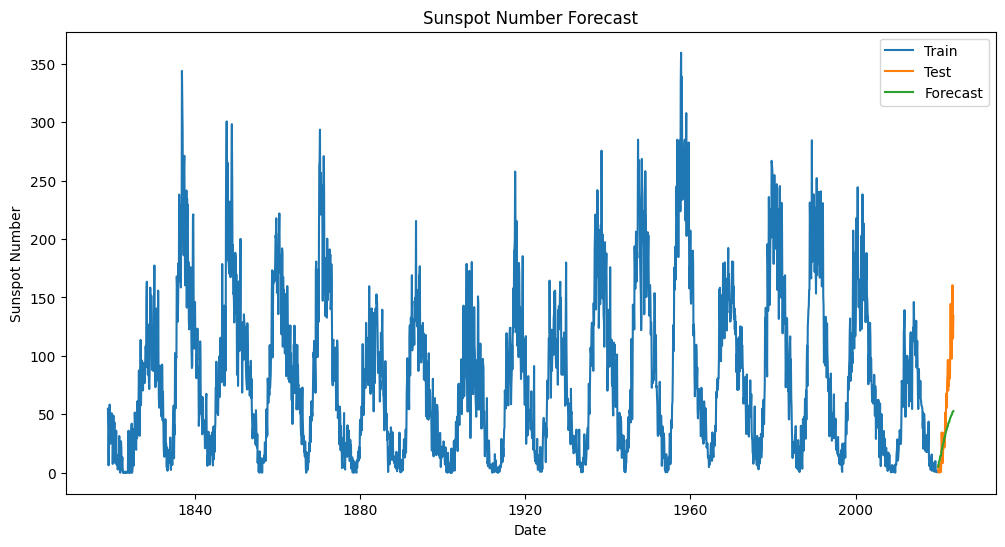

In [ ]:
# Forecast
forecast = sarima_model.predict(n_periods=len(test_df))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df["sunspot_number"], label="Train")
plt.plot(test_df.index, test_df["sunspot_number"], label="Test")
plt.plot(test_df.index, forecast, label="Forecast")
plt.title("Sunspot Number Forecast")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_df["sunspot_number"], forecast)
rmse = mean_squared_error(test_df["sunspot_number"], forecast, squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 31.693938318437276
Root Mean Squared Error: 44.32603520740041


#LSTM Model Forecasting
Now, let's use the LSTM model for sunspot number forecasting and visualize the predictions.



In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df[["sunspot_number"]])
scaled_test_data = scaler.transform(test_df[["sunspot_number"]])

# Create the LSTM input and output sequences
n_input = 12
n_features = 1

# Generate time series sequences
generator = TimeseriesGenerator(
    scaled_train_data, scaled_train_data, length=n_input, batch_size=1
)

# Define the LSTM model
model = Sequential()
model.add(Input(shape=(n_input, n_features)))
model.add(LSTM(100, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.fit(generator, epochs=50)

Epoch 1/50
  27/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0582  

c:\Users\Nikola\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2400/2400 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0117
Epoch 2/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0059
Epoch 3/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0057
Epoch 4/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0052
Epoch 5/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0053
Epoch 6/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0051
Epoch 7/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0051
Epoch 8/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0054
Epoch 9/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0052
Epoch 10/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0049
Epoch 11/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0052
Epoch 12/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0049
Epoch 13/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0052
Epoch 14/50
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0049
Epoch 15/50
2400/2400 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

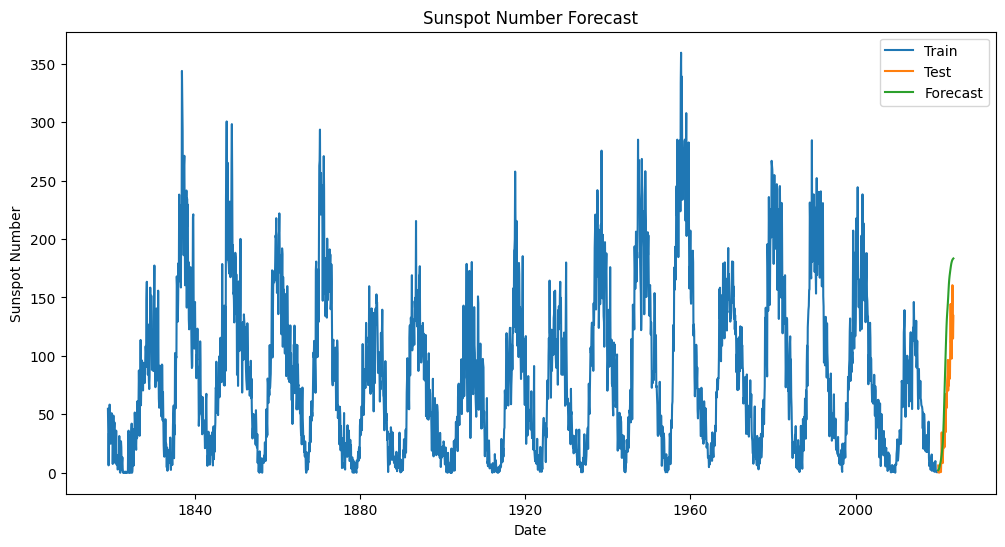

In [ ]:
# Prediction
def predict(model, scaled_data, n_input):
    preds_list = []
    batch = scaled_data[-n_input:].reshape((1, n_input, n_features))

    for _ in range(len(test_df)):  # Loop over the test set
        preds_list.append(model.predict(batch)[0])
        # Use the prediction to update the batch and remove the first value
        batch = np.append(batch[:, 1:, :], [[preds_list[-1]]], axis=1)

    # Transform predictions back to original scale
    return scaler.inverse_transform(preds_list)

# Make predictions
predictions = predict(model, scaled_train_data, n_input)

# Ensure the predicted data has the same index as the test set for plotting
predictions_indexed = pd.Series(data=predictions.flatten(), index=test_df.index)

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df["sunspot_number"], label="Train")
plt.plot(test_df.index, test_df["sunspot_number"], label="Test")
plt.plot(predictions_indexed.index, predictions_indexed, label="Forecast")
plt.title("Sunspot Number Forecast")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE
mae = mean_absolute_error(test_df["sunspot_number"], predictions.flatten())
rmse = mean_squared_error(
    test_df["sunspot_number"], predictions.flatten(), squared=False
)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 38.533412592808396
Root Mean Squared Error (RMSE): 47.899640836711285


# Prophet Model Forecasting
Lastly, let's use the Prophet model to forecast sunspot numbers and visualize the predictions.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vnvqrp3/x29a5d_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_vnvqrp3/aucvot60.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62811', 'data', 'file=/tmp/tmp_vnvqrp3/x29a5d_i.json', 'init=/tmp/tmp_vnvqrp3/aucvot60.json', 'output', 'file=/tmp/tmp_vnvqrp3/prophet_model4zzn5fsr/prophet_model-20240423002847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


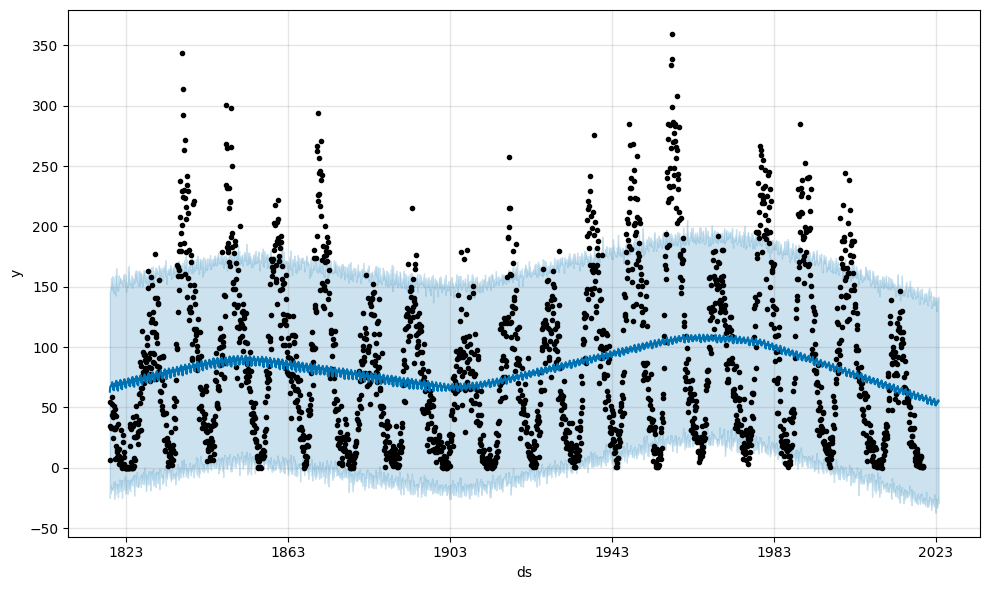

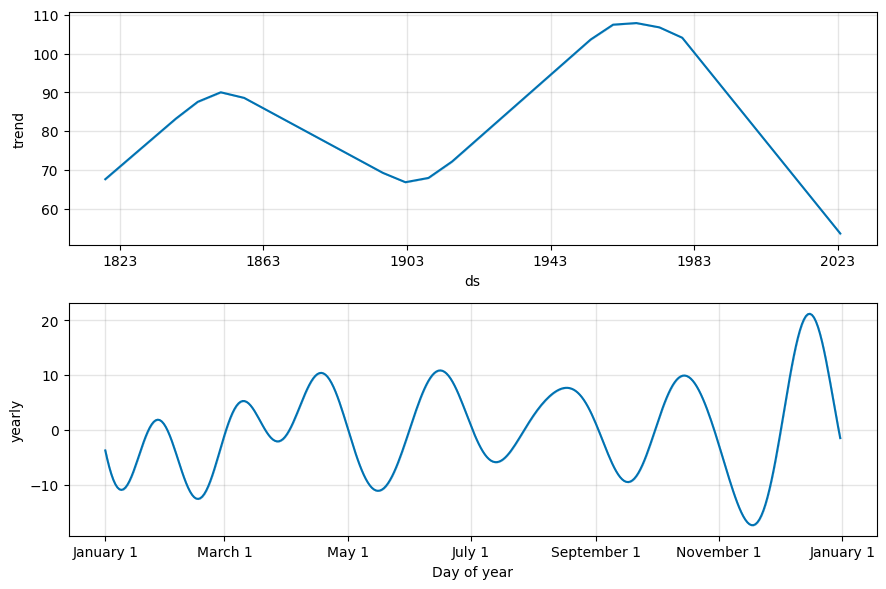

Mean Absolute Error: 43.56126448781425
Root Mean Squared Error: 49.768598625704485


In [28]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare the data
df_prophet = df_cleaned.reset_index()[["date", "sunspot_number"]].rename(
    columns={"date": "ds", "sunspot_number": "y"}
)

# Split the data into train and test sets
train_prophet = df_prophet[df_prophet["ds"] < split_date]
test_prophet = df_prophet[df_prophet["ds"] >= split_date]

# Initialize and fit the Prophet model
model = Prophet(
    yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False
)
model.fit(train_prophet)

# Make a dataframe to hold the predictions and predict future values
future = model.make_future_dataframe(periods=len(test_prophet), freq="MS")
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.show()

# Plot components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

# Extract predicted values and actual values for evaluation
y_true = test_prophet["y"].values
y_pred = forecast[-len(test_prophet) :]["yhat"].values

# Evaluate the forecast
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

In our analysis, we evaluated three different models—SARIMA, LSTM, and Prophet—for forecasting sunspot numbers. Despite employing various sophisticated techniques, none of the models performed particularly well. This outcome shows the  challenge of predicting sunspot numbers accurately.

Sunspot prediction poses several difficulties. Firstly, the sunspot phenomenon is complex and influenced by numerous factors, including solar activity, magnetic fields, and cyclical patterns. Additionally, the irregularity and nonlinearity of sunspot occurrences further complicate prediction efforts.

The SARIMA model, a traditional time series forecasting method, yielded a Mean Absolute Error (MAE) of 31.69 and a Root Mean Squared Error (RMSE) of 44.33. Although relatively low, these error metrics indicate a significant discrepancy between predicted and actual sunspot numbers.

The LSTM model, a deep learning-based approach known for its ability to capture complex temporal dependencies, exhibited slightly higher errors with an MAE of 38.53 and an RMSE of 47.90. Despite its capability to model sequential data effectively, LSTM struggled to accurately forecast sunspot numbers, indicating the challenges in predicting this phenomenon.

Lastly, the Prophet model, designed specifically for time series forecasting with built-in seasonality, produced an MAE of 43.56 and an RMSE of 49.77. While Prophet incorporates sophisticated algorithms for handling seasonality and trend changes, it too faced challenges in predicting the volatile nature of sunspot activity.